In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
data = pd.read_csv('/kaggle/input/fer2013-csv/fer2013.csv')

In [13]:
np_data = np.array(data)

<class 'list'>
2304


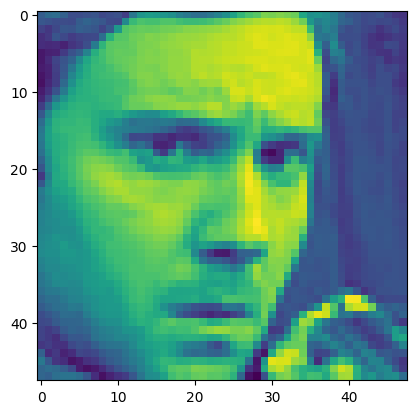

In [14]:
test_image = np_data[0][1].split(" ")
print(type(test_image))
print(len(test_image))

test_image = np.array(test_image).reshape(48, 48)
test_image.shape

test_image = test_image.astype('float')

plt.imshow(test_image)

# Data preprocessing


In [15]:
import os
from PIL import Image # Import the Image class from Pillow
import numpy as np

for i in range(len(data)):
  directory = '/kaggle/working/data/'+np_data[i][2]+'/'+str(np_data[i][0])
  if not os.path.exists(directory):
    os.makedirs(directory)

  test_image_pixels = np_data[i][1].split(" ")
  test_image_array = np.array(test_image_pixels).reshape(48, 48)
  test_image_array = test_image_array.astype('uint8') # Convert to uint8 for Pillow

  # Use Pillow to create and save the image
  img = Image.fromarray(test_image_array)
  img.save(directory+'/'+str(i)+'.jpg')

# **Training with CNN**

In [16]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras import models, layers, losses, optimizers, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

2025-05-15 21:48:06.500180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747345686.683689      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747345686.733510      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [48]:
train_dir = '/kaggle/working/data/Training'
validation_dir = '/kaggle/working/data/PublicTest'
test_dir ='/kaggle/working/data/PrivateTest'


train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    shuffle=True  # it will loop forever
)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(48, 48),
    batch_size=32,
    shuffle=False
)


Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [18]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747345796.240340      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 581,639 (2.22 MB)

 Trainable params: 581,639 (2.22 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(optimizer=optimizers.RMSprop(),
              loss=losses.categorical_crossentropy,
              metrics=['accuracy']
             )

import math, os

batch_size = 32

# count how many images are in your training dir
num_train_imgs = sum(
    len(files)
    for _, _, files in os.walk(train_dir)
)

# count how many images are in your validation dir
num_val_imgs = sum(
    len(files)
    for _, _, files in os.walk(validation_dir)
)

# compute how many batches (steps) that corresponds to
train_steps = math.ceil(num_train_imgs / batch_size)
val_steps   = math.ceil(num_val_imgs   / batch_size)

print(f"train_steps = {train_steps}, val_steps = {val_steps}")

# now call fit with the correct numbers
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=val_steps
)


train_steps = 898, val_steps = 113
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747345830.622556     126 service.cc:148] XLA service 0x7b7bb80029d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747345830.623390     126 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747345830.852899     126 cuda_dnn.cc:529] Loaded cuDNN version 90300


 18/898 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.1446 - loss: 1.9288

I0000 00:00:1747345832.601164     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


898/898 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.3116 - loss: 1.7083 - val_accuracy: 0.4932 - val_loss: 1.3546
Epoch 2/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.4980 - loss: 1.3231 - val_accuracy: 0.5180 - val_loss: 1.2645
Epoch 3/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5591 - loss: 1.1700 - val_accuracy: 0.5341 - val_loss: 1.2325
Epoch 4/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6031 - loss: 1.0564 - val_accuracy: 0.5302 - val_loss: 1.2536
Epoch 5/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6499 - loss: 0.9326 - val_accuracy: 0.5525 - val_loss: 1.2859
Epoch 6/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7141 - loss: 0.7856 - val_accuracy: 0.5442 - val_loss: 1.3130
Epoch 7/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7668 - loss: 0.6555 - val_accuracy: 0.5617 - val_loss: 1.3616
Epoch 8/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8144 - loss: 0.5261 - val_accurac

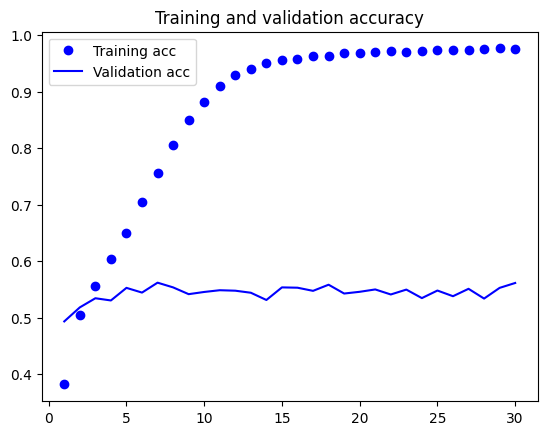

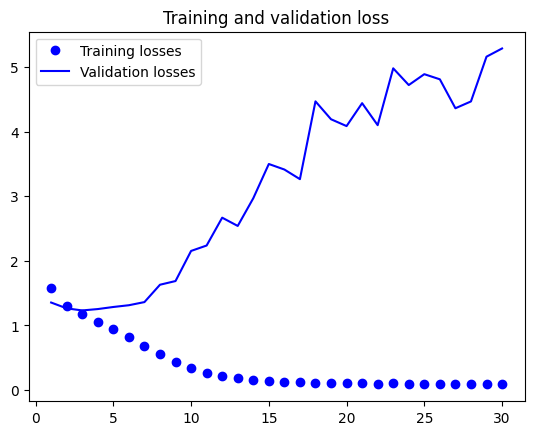

In [20]:
import matplotlib.pyplot as plt

# Change 'acc' to 'accuracy' and 'val_acc' to 'val_accuracy'
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training losses')
plt.plot(epochs, val_loss, 'b', label='Validation losses')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [61]:
# Save the trained model in HDF5 format
model.save('/kaggle/working/emotion_model_last.h5')

In [62]:
# Save training history
import pickle

with open('/kaggle/working/emotion_history_last.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [24]:
print("Image shape from generator:", train_generator.image_shape)
print("Class mode check - sample label shape:", train_generator[0][1].shape)

Image shape from generator: (48, 48, 3)
Class mode check - sample label shape: (32, 7)


Expected:

train_generator.image_shape should be (48, 48, 3)

Label shape should be (batch_size, 7) (for 7 classes)

**need to be like that for VGG16 pretrained model**

# **Try using pretrined model**

In [27]:
from keras import models, layers, optimizers, losses, metrics
from keras.applications import VGG16
import math, os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [53]:
#if you using restart run
# === Setup ===
batch_size = 32

# Data directories (assume already defined)
# train_dir, validation_dir, train_generator, validation_generator

# Count images
num_train_imgs = sum(len(files) for _, _, files in os.walk(train_dir))
num_val_imgs = sum(len(files) for _, _, files in os.walk(validation_dir))

train_steps = math.ceil(num_train_imgs / batch_size)
val_steps = math.ceil(num_val_imgs / batch_size)

In [30]:
# === VGG16 base ===
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
conv_base.trainable = False  # Freeze for phase 1

# === Build model ===
model = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # 👈 Dropout to prevent overfitting
    layers.Dense(7, activation='softmax')
])

# === Compile model ===
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy]
)

In [49]:
conv_base.trainable = False  # Freeze for phase 1

In [50]:
# === Callbacks ===
checkpoint_cb = ModelCheckpoint(
    filepath='/kaggle/working/checkpoints/best_emotion_model.weights.h5',
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    save_best_only=True,
    verbose=1
)

early_stop_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [54]:
# === Phase 1: Train top layers only ===
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=60,
    validation_data=validation_generator,
    # validation_steps=val_steps,
    initial_epoch=history.epoch[-1] + 1,  # resume from last
    callbacks=[checkpoint_cb]
)

Epoch 31/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.5971 - loss: 1.0864
Epoch 31: val_categorical_accuracy improved from 0.51741 to 0.52689, saving model to /kaggle/working/checkpoints/best_emotion_model.weights.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - categorical_accuracy: 0.5971 - loss: 1.0864 - val_categorical_accuracy: 0.5269 - val_loss: 1.2638
Epoch 32/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.6157 - loss: 1.0312
Epoch 32: val_categorical_accuracy improved from 0.52689 to 0.54054, saving model to /kaggle/working/checkpoints/best_emotion_model.weights.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - categorical_accuracy: 0.6157 - loss: 1.0312 - val_categorical_accuracy: 0.5405 - val_loss: 1.2565
Epoch 33/60
894/898 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.6444 - loss: 0.9680
Epoch 33: val_categorical_accuracy improved from 0.54054 to 0.54249, saving model to /kaggle/working/checkpoints/best_emotion_mo

In [57]:

conv_base.trainable = True

In [58]:
# Only fine-tune block5 of VGG16
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    layer.trainable = set_trainable


In [60]:
# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy]
)

# Continue training
fine_tune_history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=90,
    validation_data=validation_generator,
    validation_steps=val_steps,
    initial_epoch=history.epoch[-1] + 1,  # resume from last
    callbacks=[checkpoint_cb]
)


Epoch 61/90
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9710 - loss: 0.1034
Epoch 61: val_categorical_accuracy did not improve from 0.58401
898/898 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - categorical_accuracy: 0.9710 - loss: 0.1034 - val_categorical_accuracy: 0.5600 - val_loss: 2.2589
Epoch 62/90
894/898 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.9761 - loss: 0.0889
Epoch 62: val_categorical_accuracy did not improve from 0.58401
898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - categorical_accuracy: 0.9761 - loss: 0.0889 - val_categorical_accuracy: 0.5809 - val_loss: 2.3662
Epoch 63/90
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.9779 - loss: 0.0793
Epoch 63: val_categorical_accuracy did not improve from 0.58401
898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - categorical_accuracy: 0.9779 - loss: 0.0793 - val_categorical_accuracy: 0.5754 - val_loss: 2.2606
Epoch 64/90
896/898 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0

# **Crop the face and save the data set**

In [42]:
# 1) FACE CROPPING PIPELINE
# ------------------------

!pip install lz4
!pip install mtcnn

In [44]:
import os
import cv2

def crop_faces_haar(src_root, dst_root, target_size=(48,48)):
    # Load OpenCV's pre‑trained frontal‑face cascade
    cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
    face_cascade = cv2.CascadeClassifier(cascade_path)

    for split in ['Training', 'PublicTest', 'PrivateTest']:
        for label in os.listdir(os.path.join(src_root, split)):
            src_dir = os.path.join(src_root, split, label)
            dst_dir = os.path.join(dst_root, split, label)
            os.makedirs(dst_dir, exist_ok=True)

            for fname in os.listdir(src_dir):
                img_path = os.path.join(src_dir, fname)
                img_bgr = cv2.imread(img_path)
                if img_bgr is None:
                    continue
                gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(
                    gray,
                    scaleFactor=1.1,
                    minNeighbors=5,
                    minSize=(30, 30)
                )
                if len(faces) == 0:
                    continue

                # Pick the largest face
                x, y, w, h = max(faces, key=lambda box: box[2] * box[3])
                face = img_bgr[y:y+h, x:x+w]
                face_resized = cv2.resize(face, target_size)

                out_path = os.path.join(dst_dir, fname)
                cv2.imwrite(out_path, face_resized)

# Paths
orig_root = '/kaggle/working/data'
cropped_root = '/kaggle/working/data_cropped'

# Run the cascade‑based crop
crop_faces_haar(orig_root, cropped_root)


In [46]:
# 2) TRAIN ON CROPPED FACES
# -------------------------

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras import models, layers, losses, optimizers, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

from keras import models, layers, optimizers, losses, metrics
from keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import math, os

# point to your new cropped folders
train_dir = os.path.join(cropped_root, 'Training')
validation_dir = os.path.join(cropped_root, 'PublicTest')
test_dir = os.path.join(cropped_root, 'PrivateTest')

# generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(48,48), batch_size=32,
    class_mode='categorical', shuffle=True
)
validation_generator = test_datagen.flow_from_directory(
    validation_dir, target_size=(48,48), batch_size=32,
    class_mode='categorical', shuffle=False
)

# count steps
batch_size = 32
num_train = sum(len(files) for _,_,files in os.walk(train_dir))
num_val   = sum(len(files) for _,_,files in os.walk(validation_dir))
train_steps = math.ceil(num_train/batch_size)
val_steps   = math.ceil(num_val/batch_size)

# build & compile model
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))
conv_base.trainable = False

model = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])
model.compile(
    optimizer=optimizers.RMSprop(1e-4),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy]
)

# callbacks
checkpoint = ModelCheckpoint(
    'best_cropped.weights.h5', save_weights_only=True,
    monitor='val_categorical_accuracy', save_best_only=True, verbose=1
)
earlystop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

# phase 1
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=val_steps,
    initial_epoch=history.epoch[-1] + 1,  # resume from last
    epochs=initial_epoch+30,
    callbacks=[checkpoint]
)



Found 6628 images belonging to 7 classes.
Found 839 images belonging to 7 classes.
Epoch 1/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.2675 - loss: 1.8752
Epoch 1: val_categorical_accuracy improved from -inf to 0.41120, saving model to best_cropped.weights.h5
208/208 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - categorical_accuracy: 0.2677 - loss: 1.8749 - val_categorical_accuracy: 0.4112 - val_loss: 1.6288
Epoch 2/30
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_accuracy: 0.3379 - loss: 1.7241
Epoch 2: val_categorical_accuracy did not improve from 0.41120
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - categorical_accuracy: 0.3381 - loss: 1.7238 - val_categorical_accuracy: 0.4076 - val_loss: 1.5846
Epoch 3/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.3883 - loss: 1.6282
Epoch 3: val_categorical_accuracy improved from 0.41120 to 0.43385, saving model to best_cropped.weights.h5
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - categorical_acc

In [47]:
# phase 2: fine‑tune block5
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    layer.trainable = set_trainable

model.compile(
    optimizer=optimizers.RMSprop(1e-5),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy]
)

fine_history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=val_steps,
    initial_epoch=history.epoch[-1] + 1,
    epochs=initial_epoch+30,
    callbacks=[checkpoint]
)

Epoch 31/60
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.4540 - loss: 1.4614
Epoch 31: val_categorical_accuracy improved from 0.49702 to 0.52920, saving model to best_cropped.weights.h5
208/208 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - categorical_accuracy: 0.4541 - loss: 1.4611 - val_categorical_accuracy: 0.5292 - val_loss: 1.3470
Epoch 32/60
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.4853 - loss: 1.3730
Epoch 32: val_categorical_accuracy improved from 0.52920 to 0.53516, saving model to best_cropped.weights.h5
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - categorical_accuracy: 0.4854 - loss: 1.3729 - val_categorical_accuracy: 0.5352 - val_loss: 1.3040
Epoch 33/60
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.5131 - loss: 1.3216
Epoch 33: val_categorical_accuracy improved from 0.53516 to 0.53635, saving model to best_cropped.weights.h5
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - categorical_accuracy: 0.5131 - loss: 1.3217 